Usefull link: https://pymatching.readthedocs.io/en/latest/toric-code-example.html#Noisy-syndromes

In [1]:
# Allows us to import files from the base folder
import sys
import os
# Get the parent directory of the notebook's folder
base_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(base_dir)

# Imports
import jax
import jax.numpy as jnp

from pymatching import Matching

import matplotlib.pyplot as plt

from packages.quantum_error_correction import *
from packages.neural_network import *

from icecream import ic  # For debugging

key = jax.random.key(42)

# Initialize the QEC code that will be used

ic| nsq: 442, ndq: 441


Rate of non-trivial cases: 99.87%


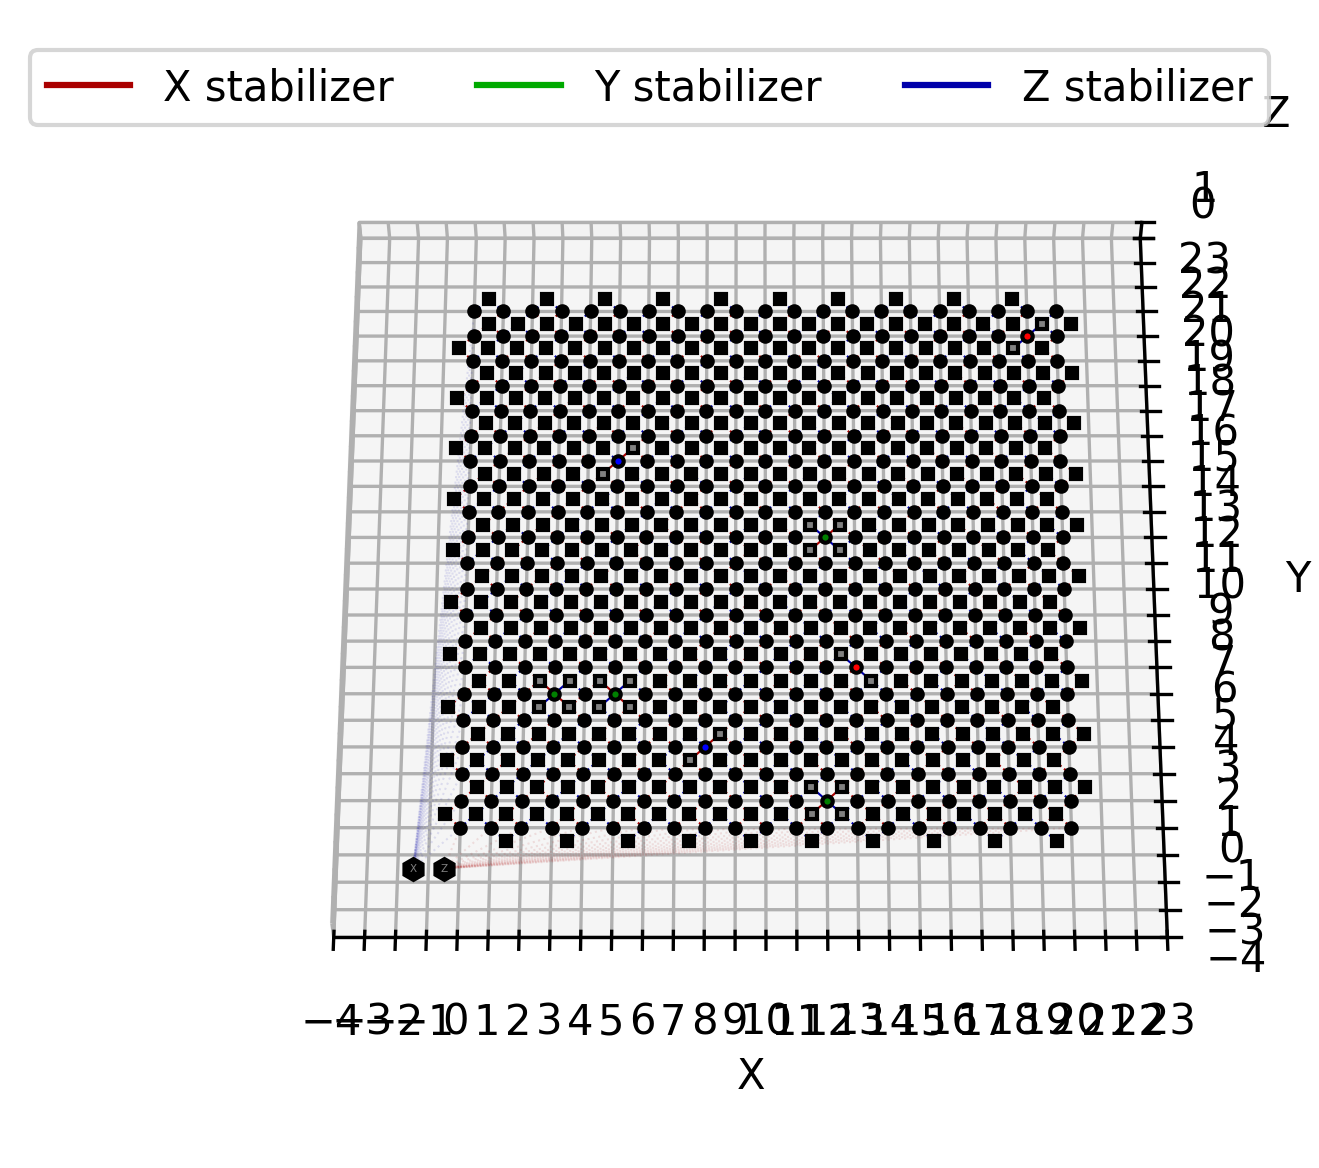

In [2]:
error_prob = [.005, .005, .005]
code_distance = 21

subkey, key = jax.random.split(key)
errors = jax_create_error_batch(*error_prob, size=code_distance**2, batch_size=1, key=subkey)

qec = QEC(surface_code_data_wls(d=code_distance))
Mx, My, Mz = qec.transformation_matrix()
nsq, ndq = Mx.shape
ic(nsq, ndq)
qec.show(errors=errors[0], marker_size=5);

print(f'Rate of non-trivial cases: {1-(1-sum(error_prob))**ndq:.2%}')

# Create a wrapper for the pymatching decoder

In [3]:
def mwpm_prediction_batch(syndromes: jnp.ndarray, Mx: jnp.ndarray, My: jnp.ndarray, Mz: jnp.ndarray) -> jnp.ndarray:
    """
    Uses the implementation of minimum weight perfect matching (MWPM) algorithm using ``pymatching``
    """
    check_matrix = jnp.append(Mx, Mz, axis=1)
    matching = Matching(check_matrix)

    recovery = jnp.array([matching.decode(syndrome) for syndrome in syndromes])
    d = recovery.shape[1] // 2
    rec_x, rec_z = recovery[:,:d], recovery[:,d:]
    return jnp.where(rec_x, jnp.where(rec_z, 2, 1), jnp.where(rec_z, 3, 0))

# View the results

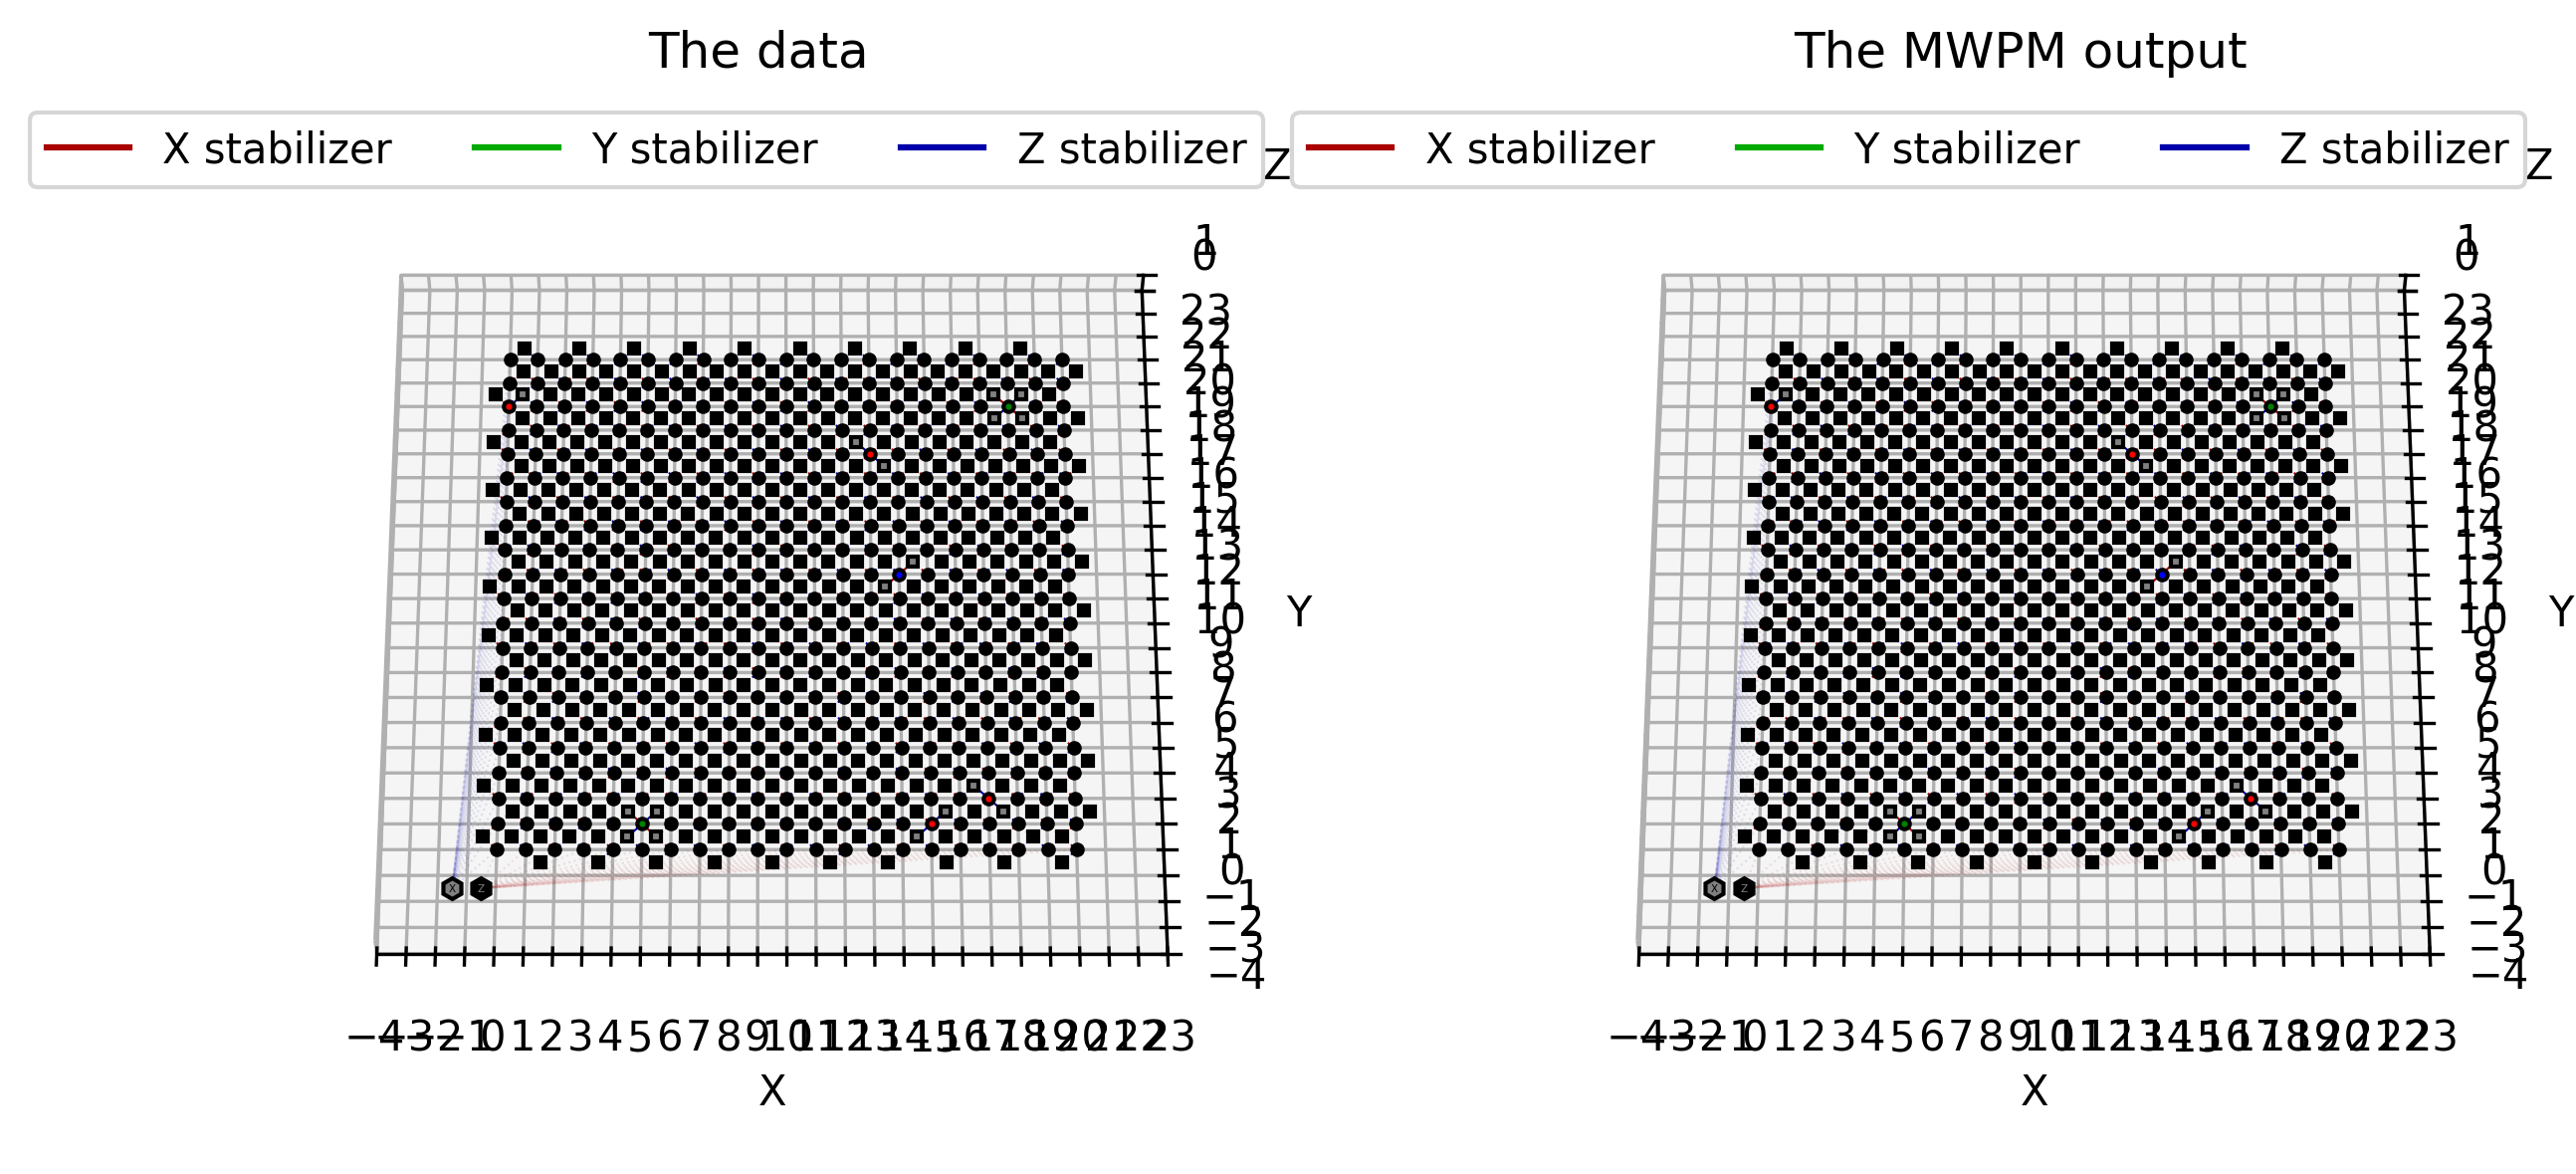

In [4]:
# Generate data
batch_size = 1
subkey, key = jax.random.split(key)
errors = jax_create_error_batch(
    px = error_prob[0],
    py = error_prob[1],
    pz = error_prob[2],
    size = ndq,
    batch_size = batch_size,
    key = subkey
)

syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)

# Run the mwpm
# The [:,:-2] and [:-2,:] or to not feed the decoder the logical stabilizers since those would normally not be accessiable
mwpm_correction = mwpm_prediction_batch(syndromes[:,:-2], Mx[:-2,:], My[:-2,:], Mz[:-2,:])

# Show the results
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'}, dpi=300)
fig.set_figwidth(10)
fig.set_figheight(10)
qec.show(axis=ax1, errors=errors[0], marker_size=5, title="The data")
qec.show(axis=ax2, errors=mwpm_correction[0], marker_size=5, title="The MWPM output")
plt.show()

# Calculate number of logical errors vs number of physical errors

In [5]:
resolution = 1000
batch_size = 500

errors = jnp.array([
    jax_create_error_batch(
        px = p,
        py = p,
        pz = p,
        size = ndq,
        batch_size = batch_size,
        key = subkey
    ) for p in jnp.linspace(0,1/3,resolution)
]).reshape((batch_size*resolution, code_distance**2))
errors.shape

(500000, 441)

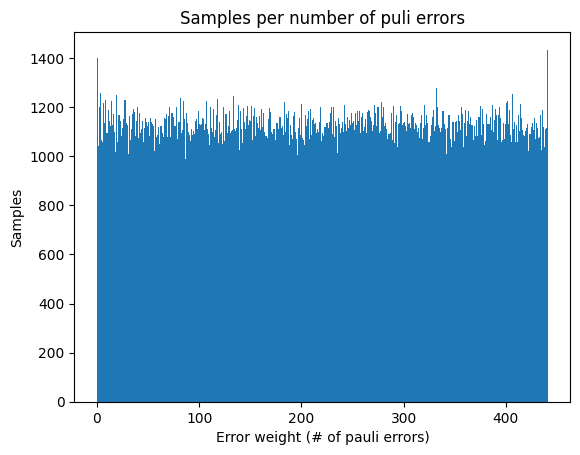

In [6]:
plt.plot()
plt.hist((errors != 0).sum(axis=1), bins=ndq+1)
plt.title("Samples per number of puli errors")
plt.xlabel("Error weight (# of pauli errors)")
plt.ylabel("Samples")
plt.show()

In [7]:
syndromes = jax_get_syndromes_batch(Mx, My, Mz, errors)
mwpm_correction = mwpm_prediction_batch(syndromes[:,:-2], Mx[:-2,:], My[:-2,:], Mz[:-2,:])
mwpm_syndromes = jax_get_syndromes_batch(Mx, My, Mz, mwpm_correction)
logical_errors = (syndromes[:,-2:] + mwpm_syndromes[:,-2:]) % 2

In [8]:
error_distances = (errors != 0).sum(axis=1)
logical_I = jnp.equal(logical_errors, jnp.array([0,0])).all(axis=1).astype(int)
logical_X = jnp.equal(logical_errors, jnp.array([1,0])).all(axis=1).astype(int)
logical_Y = jnp.equal(logical_errors, jnp.array([1,1])).all(axis=1).astype(int)
logical_Z = jnp.equal(logical_errors, jnp.array([0,1])).all(axis=1).astype(int)

total = jnp.bincount(error_distances, length=ndq+1)
cI = jnp.bincount(error_distances, weights=logical_I, length=ndq+1)
cX = jnp.bincount(error_distances, weights=logical_X, length=ndq+1)
cY = jnp.bincount(error_distances, weights=logical_Y, length=ndq+1)
cZ = jnp.bincount(error_distances, weights=logical_Z, length=ndq+1)

pI = cI / total
pX = cX / total
pY = cY / total
pZ = cZ / total

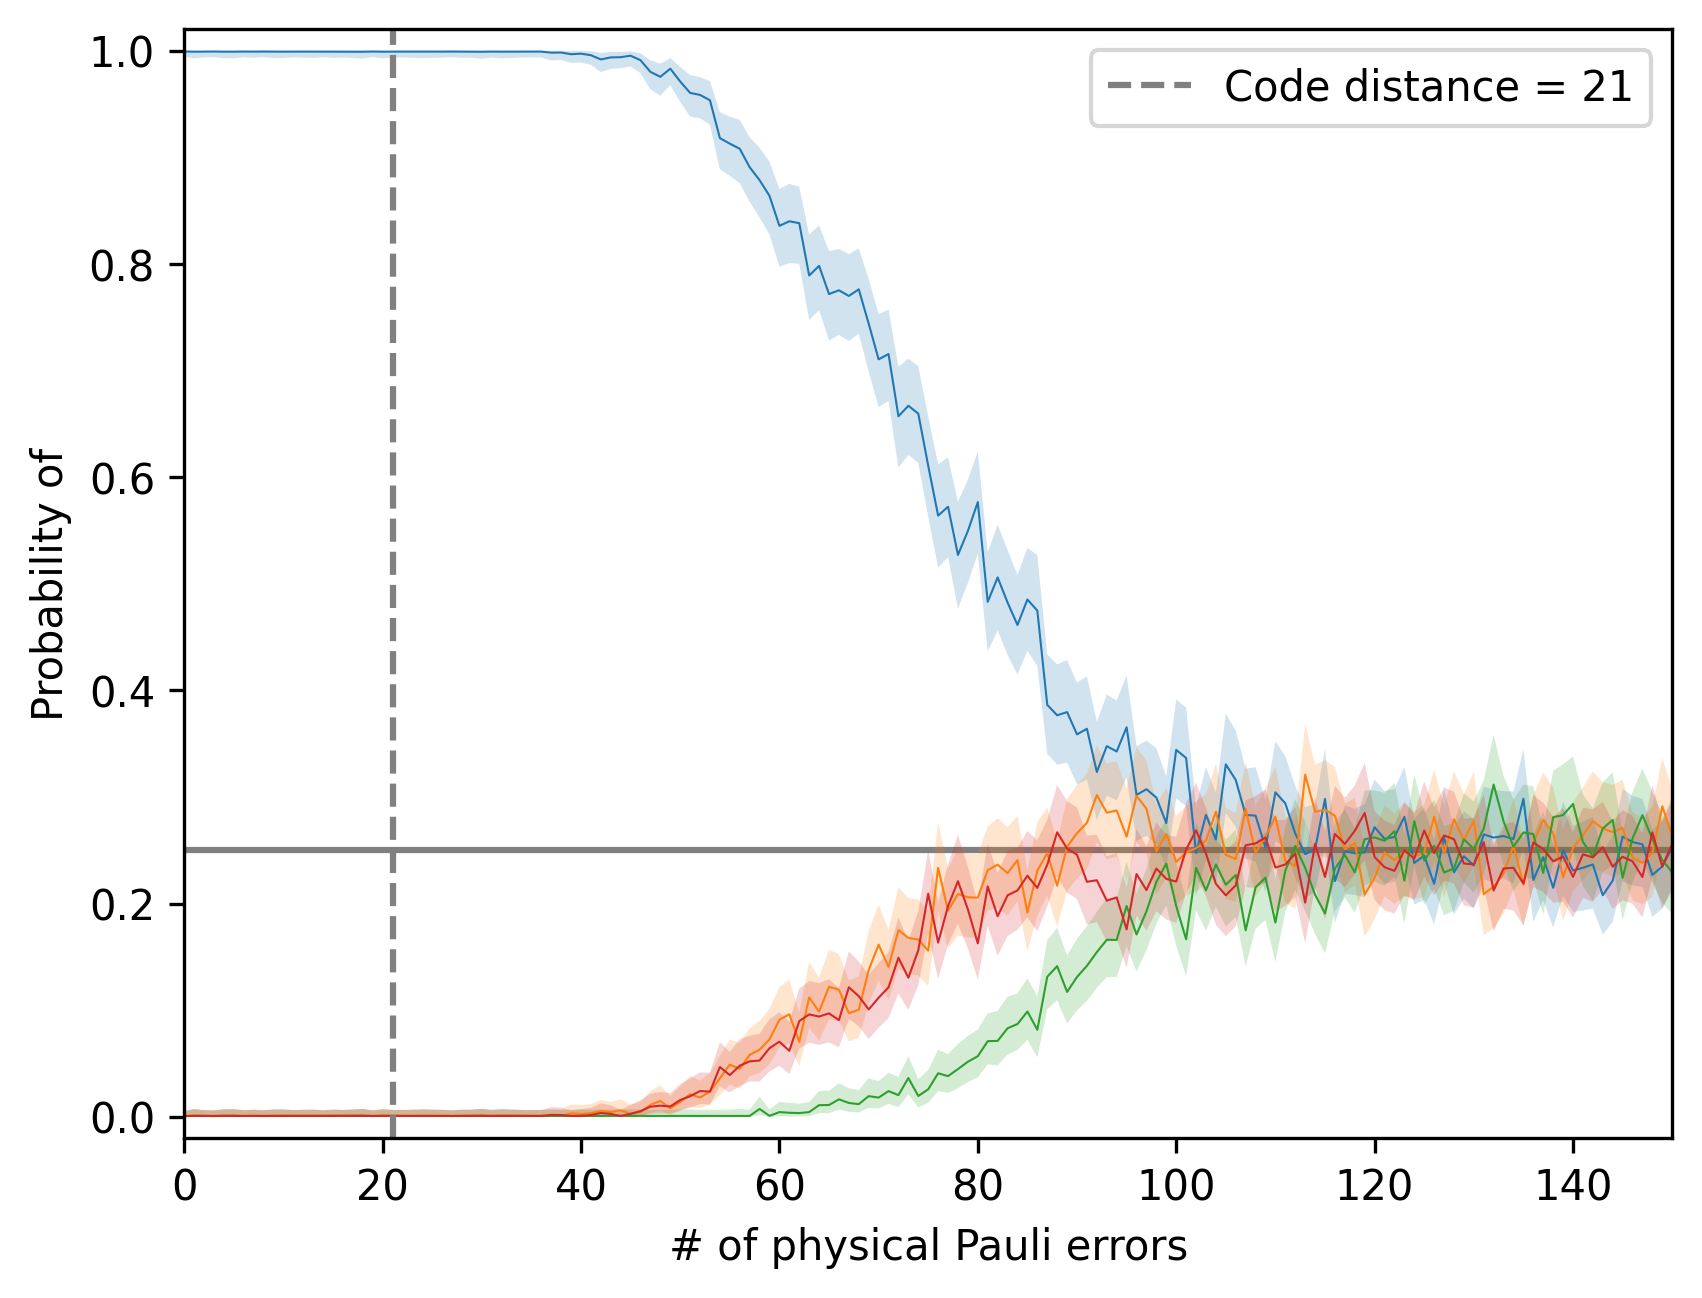

In [25]:
from scipy.stats import beta as beta_dist

plt.figure(dpi=300)
for count in [cI, cX, cY, cZ]:
    # alpha and beta parameters of the beta distribution
    alpha = count+1
    beta = total-count+1

    # Mean, lower and upper bound
    confidense = .999
    mean = alpha / (alpha + beta)
    lower = beta_dist.ppf((1-confidense)/2, alpha, beta)
    upper = beta_dist.ppf(1-(1-confidense)/2, alpha, beta)

    # Calculate the error bars
    lower_error = mean - lower
    upper_error = upper - mean

    # plt.errorbar(jnp.arange(0, ndq+1), mean, yerr=[lower_error, upper_error], ls='--', lw=.5)
    plt.plot(jnp.arange(0, ndq+1), mean, lw=.5)
    plt.fill_between(jnp.arange(0, ndq+1), lower, upper, alpha=.2)
plt.vlines(code_distance, -.02, 1.02, color='gray', ls='--', label=f"Code distance = {code_distance}")
plt.hlines(1/4, 0, code_distance**2, color='gray', ls='-', zorder=-1)
plt.xlim(0, code_distance**2)
plt.ylim(-.02, 1.02)
plt.legend()
plt.xlabel("# of physical Pauli errors")
plt.ylabel("Probability of")
plt.xlim(0,150)
plt.show()

/tmp/ipykernel_413069/4259243924.py:13: RuntimeWarning: invalid value encountered in sqrt
  lower_error = np.maximum(0, np.sqrt(variance) * (1 - skewness))
/tmp/ipykernel_413069/4259243924.py:14: RuntimeWarning: invalid value encountered in sqrt
  upper_error = np.maximum(0, np.sqrt(variance) * (1 + skewness))


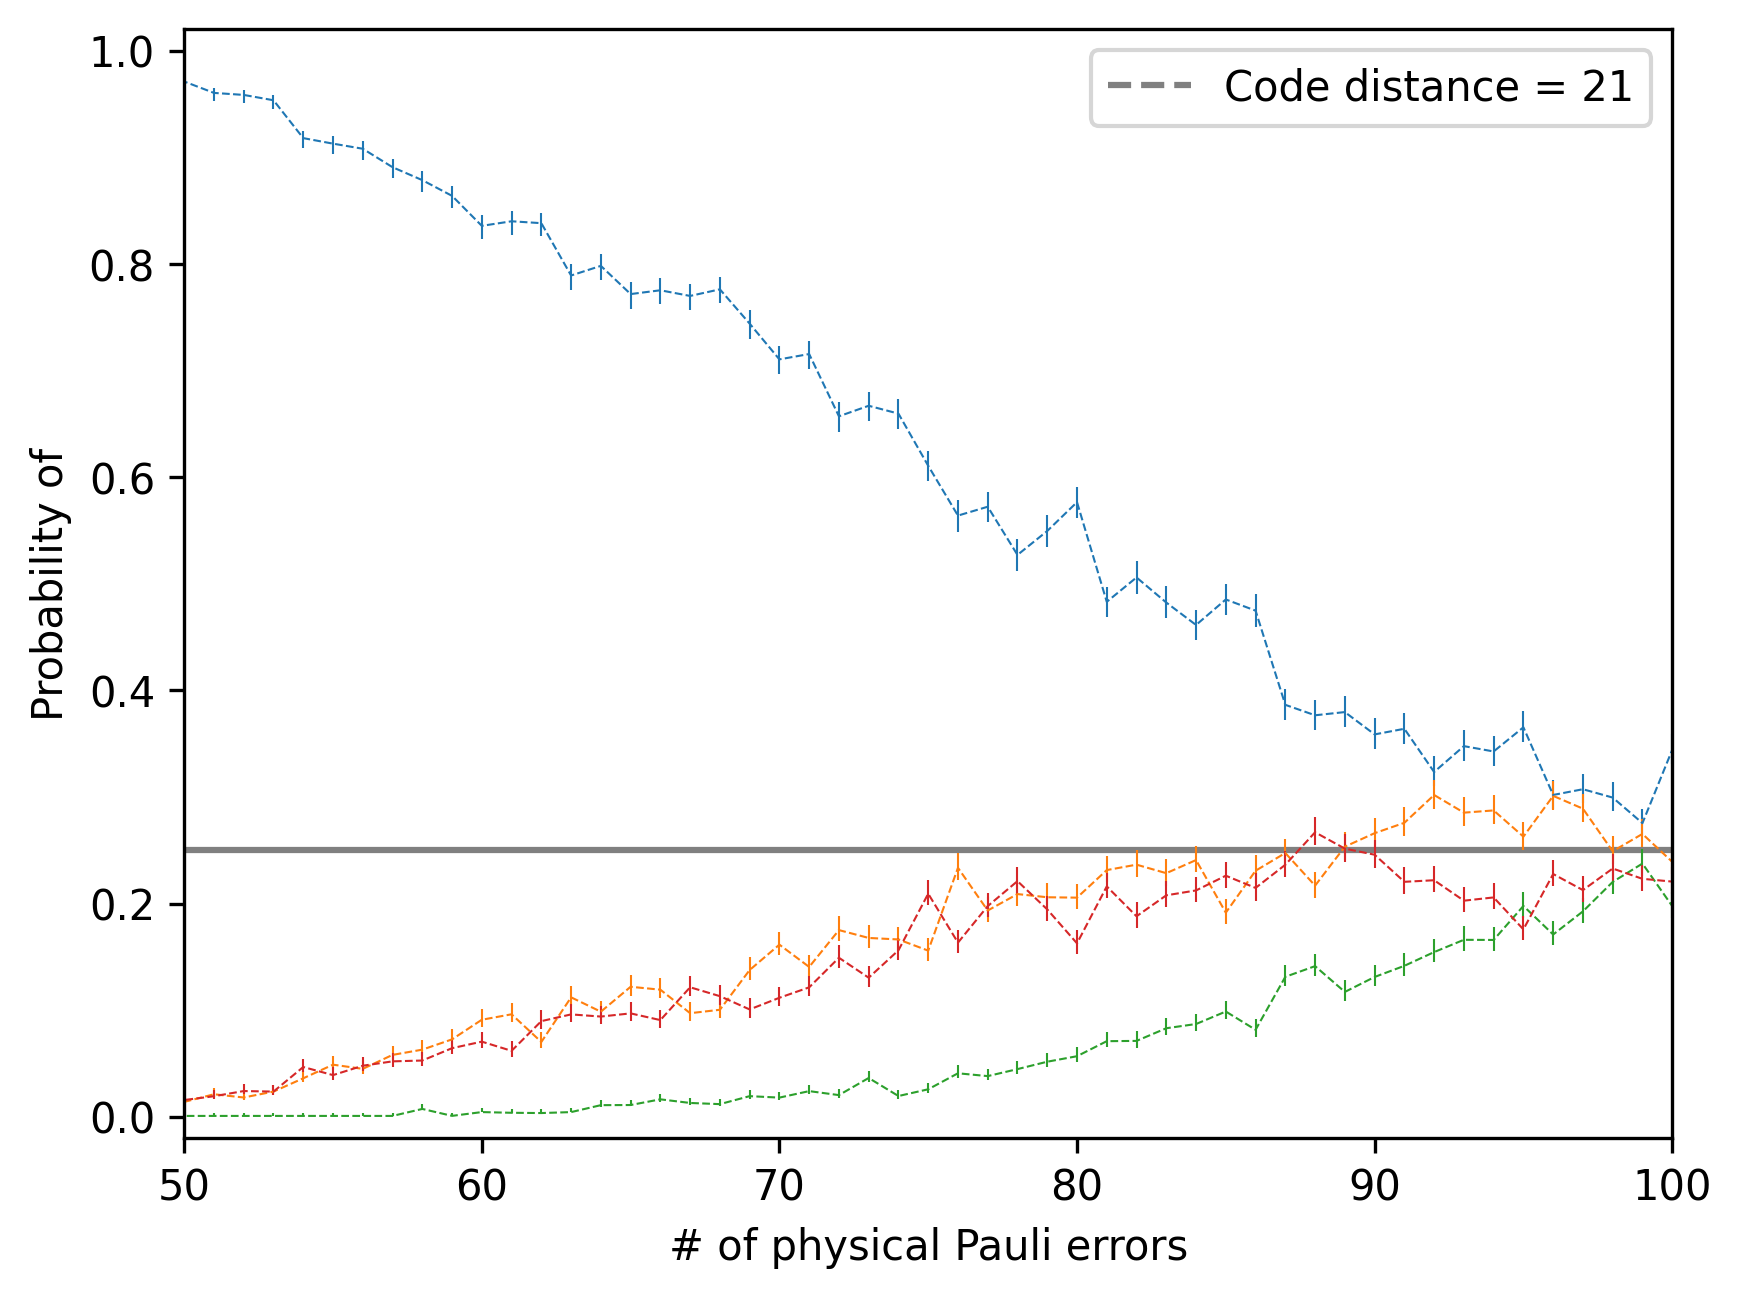

In [10]:
plt.figure(dpi=300)
for count in [cI, cX, cY, cZ]:
    # alpha and beta parameters of the beta distribution
    alpha = count+1
    beta = total-count+1

    # Mean, variance, and skewness of the Beta distribution
    mean = alpha / (alpha + beta)
    variance = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1))
    skewness = 2 * (beta - alpha) * np.sqrt(alpha + beta + 1) / ((alpha + beta + 2) * np.sqrt(alpha * beta))

    # Asymmetric error bounds
    lower_error = np.maximum(0, np.sqrt(variance) * (1 - skewness))
    upper_error = np.maximum(0, np.sqrt(variance) * (1 + skewness))

    plt.errorbar(jnp.arange(0, ndq+1), mean, yerr=[lower_error, upper_error], ls='--', lw=.5)
plt.vlines(code_distance, -.02, 1.02, color='gray', ls='--', label=f"Code distance = {code_distance}")
plt.hlines(1/4, 0, code_distance**2, color='gray', ls='-', zorder=-1)
plt.xlim(0, code_distance**2)
plt.ylim(-.02, 1.02)
plt.legend()
plt.xlabel("# of physical Pauli errors")
plt.ylabel("Probability of")
plt.xlim(50,100)
plt.show()

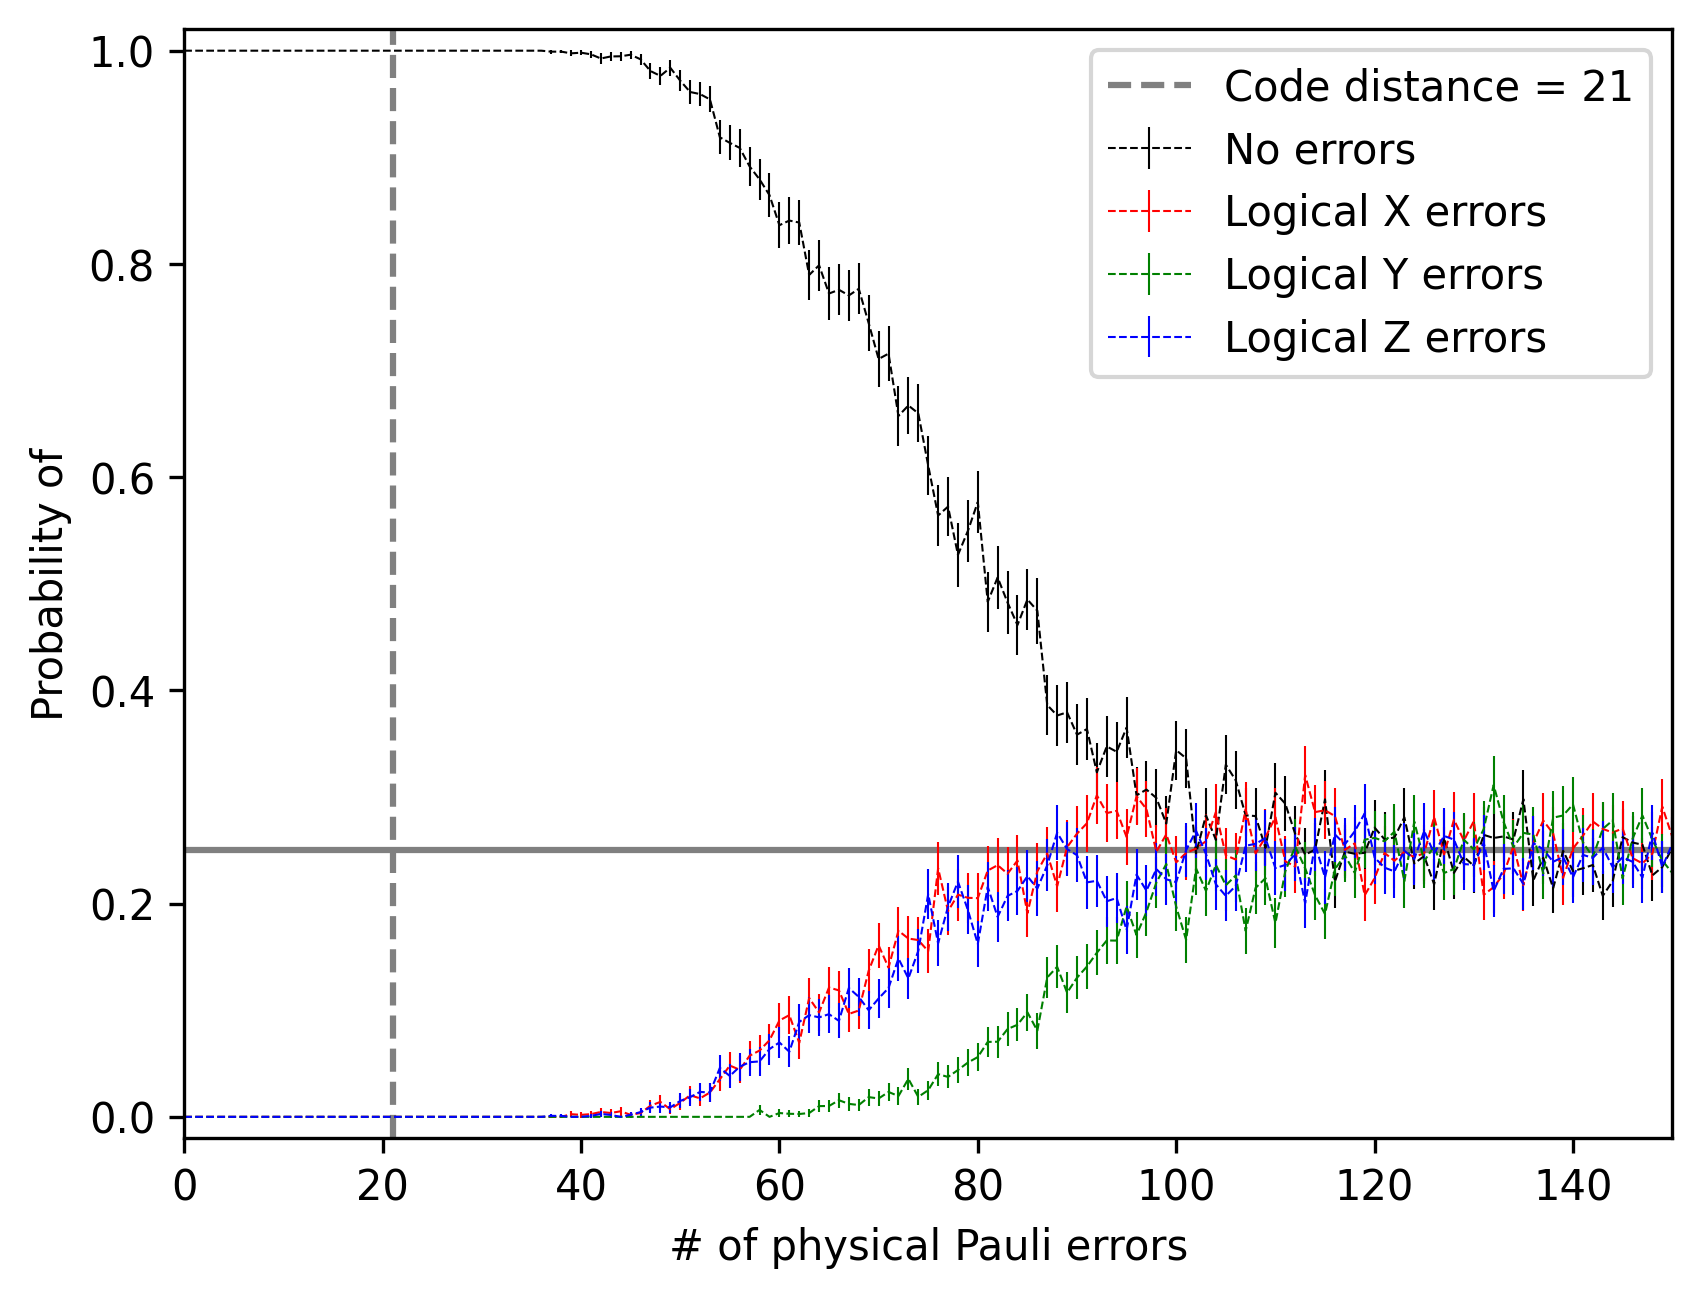

In [23]:
plt.figure(dpi=300)
plt.errorbar(jnp.arange(0, ndq+1), pI, yerr=1.96*jnp.sqrt(pI*(1-pI) / total), ls='--', lw=.5, c='k', label="No errors")
plt.errorbar(jnp.arange(0, ndq+1), pX, yerr=1.96*jnp.sqrt(pX*(1-pX) / total), ls='--', lw=.5, c='r', label="Logical X errors")
plt.errorbar(jnp.arange(0, ndq+1), pY, yerr=1.96*jnp.sqrt(pY*(1-pY) / total), ls='--', lw=.5, c='g', label="Logical Y errors")
plt.errorbar(jnp.arange(0, ndq+1), pZ, yerr=1.96*jnp.sqrt(pZ*(1-pZ) / total), ls='--', lw=.5, c='b', label="Logical Z errors")
plt.vlines(code_distance, -.02, 1.02, color='gray', ls='--', label=f"Code distance = {code_distance}")
plt.hlines(1/4, 0, code_distance**2, color='gray', ls='-', zorder=-1)
plt.xlim(0, code_distance**2)
plt.ylim(-.02, 1.02)
plt.legend()
plt.xlabel("# of physical Pauli errors")
plt.ylabel("Probability of")
plt.xlim(0,150)
plt.show()